# Dataset Preprocessing
In this notebook, we inspect the provided dataset, remove unnessary stuff and convert it into a format support by a our object detection code

In [1]:
import pandas as pd
import sys
import os


import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
# %matplotlib notebook
import torch
import os
from PIL import Image

In [2]:
print(torch.rand(5, 3))
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print (torch.cuda.current_device())
print (torch.version.cuda)

tensor([[0.3133, 0.1400, 0.1591],
        [0.2416, 0.1862, 0.1119],
        [0.9499, 0.1406, 0.4362],
        [0.8516, 0.4488, 0.7162],
        [0.3712, 0.0638, 0.4992]])
True
NVIDIA GeForce RTX 3070 Laptop GPU
0
12.6


### Load the dataset and check shapes

Training Labels

In [3]:
x_train = np.load (file= r"KITTI\x_train-002.npy")
x_train.shape

(3712, 185, 306, 3)

Training Labels

In [4]:
y_train = np.load (file= r"KITTI\y_train.npy", allow_pickle= True)
y_train.shape

(3712,)

Test Images

In [5]:
x_test = np.load (file= r"KITTI\x_test-001.npy", allow_pickle= True)
x_test.shape

(3769, 185, 306, 3)

In [6]:
y_train[1]

{'classes': [0],
 'boxes': [array([ 90.89 , 154.12 , 142.385, 210.655])],
 'truncs': ['0.00'],
 'occls': ['0']}

### Remove images without labels from the dataset
Some images such as image zero only have a placeholder label "class" : []. We will purge them so that they don't cause problems later on

In [7]:
y_train_filt = []
kept_indices_list = []

for i, dict in enumerate (y_train):
    if (dict.get("classes") != []):
        y_train_filt.append(dict)
        kept_indices_list.append(i)

y_train_filt = np.array(y_train_filt)
kept_indices_list = np.array(kept_indices_list)
kept_indices_list


array([   1,    2,    3, ..., 3709, 3710, 3711], shape=(3177,))

In [8]:
import gc
gc.collect()

31

In [9]:
# Remaining Images
x_train_filt = x_train[kept_indices_list]
x_train_filt.shape

(3177, 185, 306, 3)

In [10]:
# Remaining Labels
y_train_filt.shape

(3177,)

### Plot some images

float32


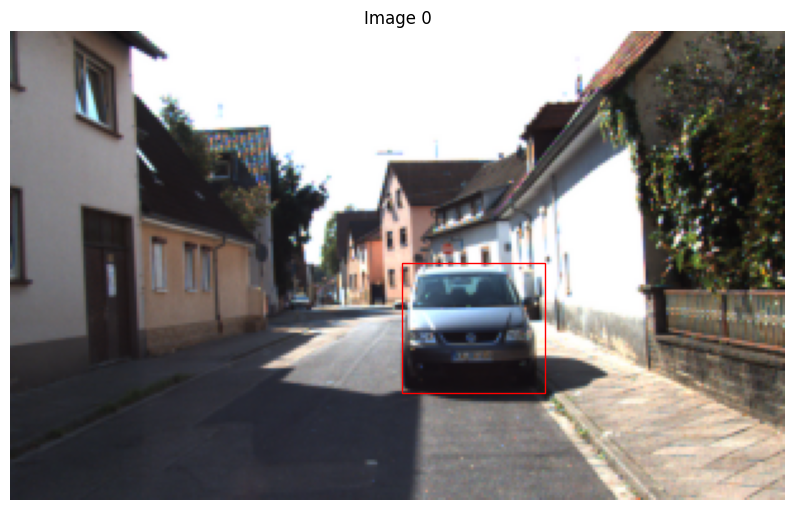

float32


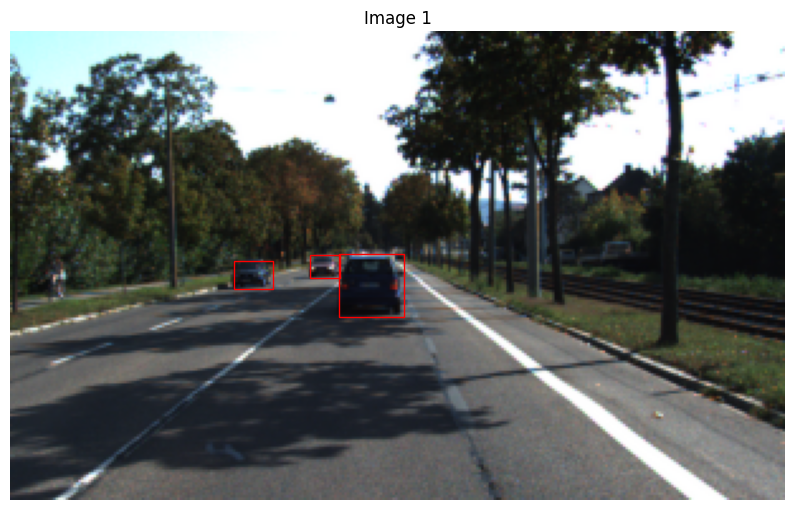

float32


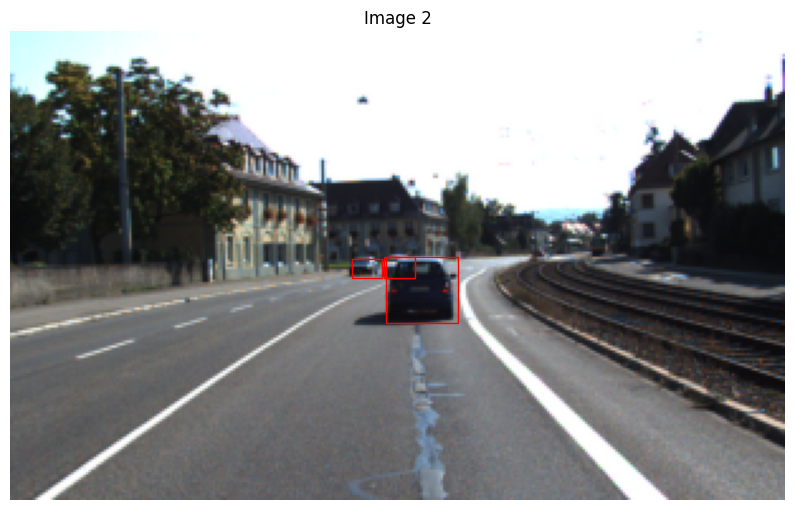

float32


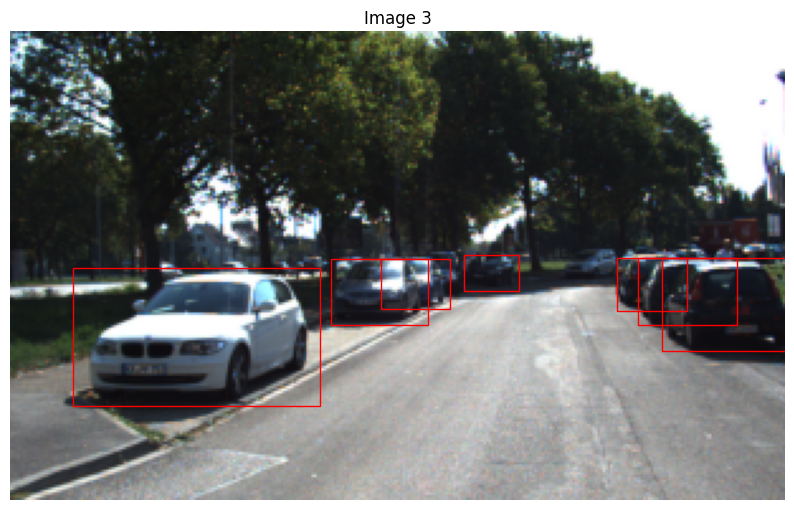

float32


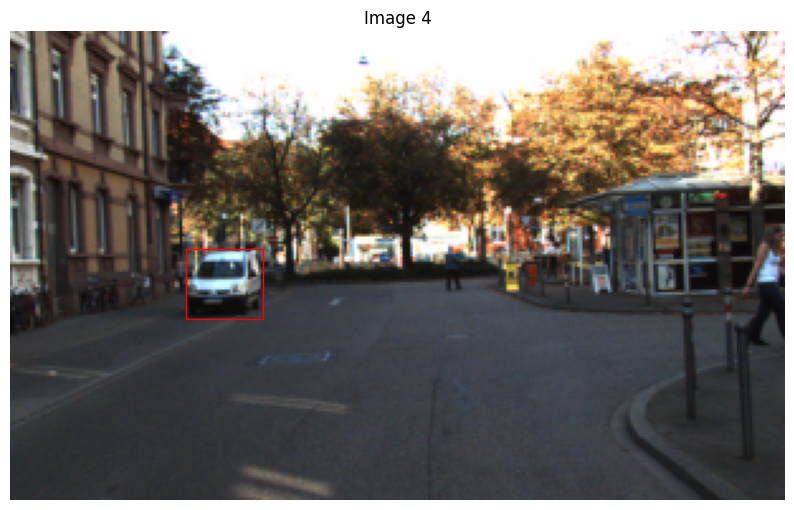

In [11]:
from provided_utils import print_image_orignal
for i in range(5):
    # Colormap for plotted bounding boxes 
    cmap = {0: "r", "Pedestrian": "g", "Cyclist": "b", "Van": "yellow", "Truck": "black"}

    # we deleted labels other than cars

    # Get boxes & classes for specific image
    im_number = i
    boxes = y_train_filt[im_number]["boxes"]
    classes = y_train_filt[im_number]["classes"]
    print(x_train_filt.dtype)

    # Plot image
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(x_train_filt[im_number, ...])
    ax.axis("off")
    plt.title(f"Image {im_number}")

    # Plot colored bounding boxes
    for bbox, cls in zip(boxes, classes):
        try:
            cl = cmap[cls]
        except:
            cl = cmap["Misc"]
        # Add rectangle (x,y), width, heigth
        height = bbox[2] - bbox[0]
        width = bbox[3] - bbox[1]
        rect = patches.Rectangle((bbox[1], bbox[0]), width, height, linewidth=1, edgecolor=cl, facecolor="none")
        ax.add_patch(rect)

    plt.show()
    plt.close(fig)

### Converting Format and structure of the dataset
Currently the provided data has bounding boxes in format:
X_min, Y_min, X_max, Y_max. 
Where X is along the height axis of the image and Y is along the width axis of the image. These coordinates are also absolute pixel positions. 

We will change them into the format:
X_centre, Y_centre, Width, Height. 
Where X_centre is the centre coordinate of the box along the width axis, Y_centre is the centre coordinate of the box along the height axis. We will also normalize them with image size. So they are between 0-1. Where 1 corresponds to the ends of the image and zero to the start.

In [12]:
image_width = x_train_filt.shape[2]
image_height = x_train_filt.shape[1]


check format of predictions for later use

In [13]:
pred_example = np.load (r"KITTI/pred_example.npy", allow_pickle= True)
pred_example.shape

(2,)

In [14]:
pred_example

array([{'boxes': array([[ 91, 154, 142, 211],
              [ 90, 100, 142, 128]]), 'classes': array([0., 0.]), 'scores': array([1. , 0.7])},
       {'boxes': array([[ 87, 129, 112, 155],
              [ 90,  88, 101, 104],
              [ 88,  10, 110,  20],
              [ 88, 118,  97, 129]]), 'classes': array([0., 0., 0., 0.]), 'scores': array([0.9, 0.8, 0.7, 0.5])}],
      dtype=object)

Create directories for the dataset

KITTI_YOLO
- images
- labels

In [15]:
dataset_dir = os.path.join(os.getcwd(), "KITTI_YOLO")
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

Convert format of boundings boxs and images and save in a new directory structure

In [16]:
# y_train_filt["occ"]
y_train_filt[17]["truncs"]

['0.00',
 '0.12',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00']

In [ ]:
# keep track of image id and corresponding label id so that we can correctly assign image to its label .txt
image_to_annotation_id_records = []

# Iterate through every image and label in np arrays
for idx, (annotation, image) in enumerate(zip(y_train_filt, x_train_filt)):
    image_id  = f"{idx}.jpg"
    label_id  = f"{idx}.txt"

    label_lines = []
    
    # Switch X, Y axis. Calculate X_centre, Y_centre, Width, Height normalized to image sizes.
    # Add corresponding class label at the start of the list, followed by the bounding box coordinates. 
    # Append the string to a list
    for trunc, box, class_idx in zip(annotation["truncs"], annotation["boxes"], annotation["classes"]):

        # if the bounding box is exceeding image limits, skip this particular bounding box and class label
        if float(trunc) > 0 :
            continue
        
        else: 
            # Get the bounding box coordinates
            xmin, ymin, xmax, ymax = box

            # Bound the bounding boxes with in the bounds of the image xD
            xmin = max(int(0), min(xmin, image_height))
            ymin = max(int(0), min(ymin, image_width))

            xmax = max(int(0), min(xmax, image_height))
            ymax = max(int(0), min(ymax, image_width))
        
            # Convert the bounding box to YOLO format (X_center, Y_centre, Width, Height) 
            # all normalized to image width and height
            x_centre = (((ymax -ymin)/2)+ymin)/image_width
            y_centre = (((xmax-xmin)/2)+xmin)/image_height

            box_width = (ymax-ymin)/image_width
            box_height = (xmax-xmin)/image_height

            # label_lines.append(f"{class_idx} {x_centre:.6f} {y_centre:.6f} {box_width:.6f} {box_height:.6f}")
            label_lines.append(f"{class_idx} {x_centre} {y_centre} {box_width} {box_height}")

    label_txt_path = os.path.join(labels_dir, label_id)

    # open a txt file, write the label strings at separate lines in the txt file by joining with "/n"
    with open (os.path.join(label_txt_path), mode= "w") as file:
        file.write("\n".join(label_lines))

    # also save the corresponding image, convert its range to 0-255, saving using PIL
    image_jpg_path = os.path.join(images_dir, image_id)

    image = (image*255).astype(np.uint8)
    img_pil = Image.fromarray(image)
    img_pil.save(image_jpg_path)

    # record the image id and the corresponding label id
    image_to_annotation_id_records.append({"image_id": image_id, "label_id": label_id})

# save the id records to a csv
records_df = pd.DataFrame(data= image_to_annotation_id_records)
records_df.to_csv(path_or_buf= os.path.join(dataset_dir, "all.csv"), index= False)

Divide the annotations into training and validation sections. The first 80 percent of the samples are reserved for training and rest of them for validation

In [18]:
records_df =pd.read_csv(filepath_or_buffer= os.path.join(dataset_dir, "all.csv"))

In [19]:
n_samples = records_df.shape[0]

n_train_samples = int(0.80*n_samples)
n_val_samples = int(n_samples-n_train_samples)

n_samples, n_train_samples, n_val_samples

(3177, 2541, 636)

In [20]:
# train, val split
train_records_df = records_df[:n_train_samples]
val_records_df = records_df[n_train_samples:]

# save to separate csv files
train_records_df.to_csv(path_or_buf= os.path.join(dataset_dir, "train.csv"), index= False)
val_records_df.to_csv(path_or_buf= os.path.join(dataset_dir, "val.csv"), index= False)

Also split the given train npy into train and val files but with original format

In [26]:
x_train_ = x_train_filt[:n_train_samples,...]
y_train_ = y_train_filt[:n_train_samples,...]

x_val_ = x_train_filt[n_train_samples:,...]
y_val_ = y_train_filt[n_train_samples:,...]

In [28]:
x_train_.shape[0], x_val_.shape[0]

(2541, 636)

In [31]:
np.save(file= r"KITTI_YOLO//x_train_", arr= x_train_)
np.save(file= r"KITTI_YOLO//y_train_", arr= y_train_)

np.save(file= r"KITTI_YOLO//x_val_", arr= x_val_)
np.save(file= r"KITTI_YOLO//y_val_", arr= y_val_)

### Repeat the above process for the test set
We only have access to the inputs of the test set and not the labels. We will convert the input samples into images into the same dataset structure as above. We will also create dummy labels.

In [21]:
# keep track of image id and corresponding label id so that we can correctly assign image to its label .txt
image_to_annotation_id_records = []

# Iterate through every image in np arrays
for idx, (image) in enumerate(x_test):
    image_id  = f"{6000+idx}.jpg"  # Test images arbitrarily start after 6000
    label_id  = f"{6000+idx}.txt"

    label_lines = []
    
    # Create a dummy label in the same format as those used for train set and validation set
    class_idx = 0
    x_centre = 0.018300653594771222
    y_centre = 0.6516756756756756 
    box_width = 0.036601307189542444
    box_height = 0.243081081081081

    # label_lines.append(f"{class_idx} {x_centre:.6f} {y_centre:.6f} {box_width:.6f} {box_height:.6f}")
    label_lines.append(f"{class_idx} {x_centre} {y_centre} {box_width} {box_height}")

    label_txt_path = os.path.join(labels_dir, label_id)

    # open a txt file, write the label strings at separate lines in the txt file by joining with "/n"
    with open (os.path.join(label_txt_path), mode= "w") as file:
        file.write("\n".join(label_lines))

    # also save the corresponding image, convert its range to 0-255, saving using PIL
    image_jpg_path = os.path.join(images_dir, image_id)

    image = (image*255).astype(np.uint8)
    img_pil = Image.fromarray(image)
    img_pil.save(image_jpg_path)

    # record the image id and the corresponding label id
    image_to_annotation_id_records.append({"image_id": image_id, "label_id": label_id})

# save the id records to a csv
records_df = pd.DataFrame(data= image_to_annotation_id_records)
records_df.to_csv(path_or_buf= os.path.join(dataset_dir, "test.csv"), index= False)